In [2]:
#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install numpy

#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/ec2-user/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
#load a default seaborn dataset, display simple stats about data size, and then print the data's head
df = pd.DataFrame(sns.load_dataset('iris'))
print ('shape of the data frame' + str(df.shape))
print (df.groupby(['species']).size())
df.head(50)

shape of the data frame(150, 5)
species
setosa        50
versicolor    50
virginica     50
dtype: int64


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


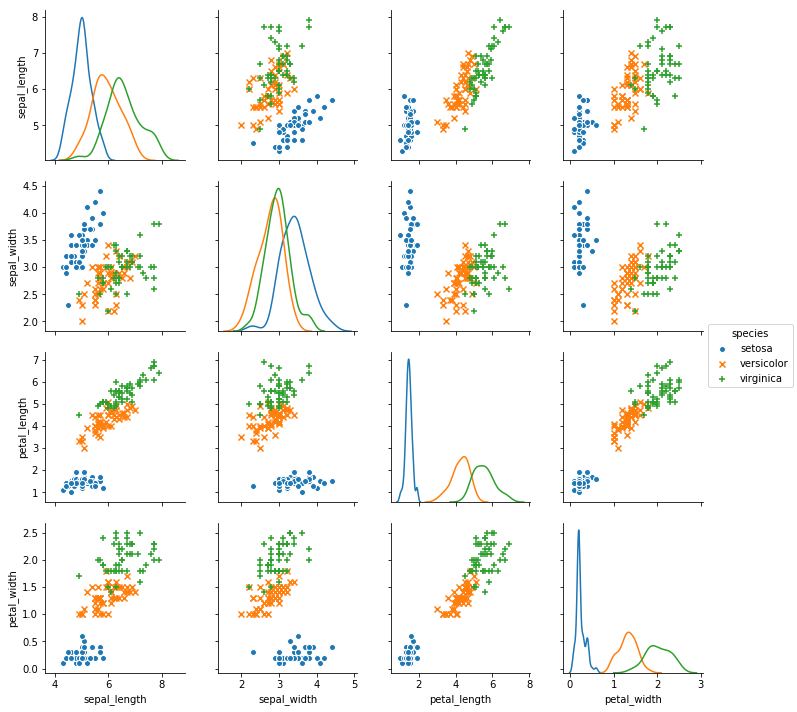

In [9]:

#showoff some of what seaborn can do#showoff  
sns.pairplot(df, hue="species", diag_kind="kde",markers=['o','x','+'])

In [10]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['species']=='versicolor', 1,0)
print (df.groupby(['y']).size())

y
0    100
1     50
dtype: int64


In [11]:
#split into train and test
X=df.drop('species',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))

the number in training set: 112
the number in test set: 38


In [13]:
#Randomized search for model selection
clf = RandomForestClassifier(n_estimators=50)
# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 5),
              "min_samples_leaf": sp_randint(1, 5),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV examined 30 candidate parameter settings.
Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 4}

Model with rank: 1
Mean OOB score: 0.964 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_le

In [14]:
#2.5 Train the random forest according to the best paramater setting given above. Show model outputs.

#YOUR HOMEWORK IS TO SWITCH RANDOM FOREST CLASSIFIED WITH ANOTHER CLASSIFIER FROM THE SCIKIT LEARN API
#http://scikit-learn.org/stable/
clf = RandomForestClassifier(n_estimators=50, oob_score=True, max_features=3, criterion='gini',
                             bootstrap=True,min_samples_split=2,min_samples_leaf=4,max_depth=3)

clf = clf.fit(X_train, y_train)

importances = clf.feature_importances_
names = X.columns
items=sorted(zip(map(lambda r: round(r, 3), clf.feature_importances_), names), reverse=True)

print ('\nfeature importance ')
for r in items:
    print(str(round(r[0],4))+' '+r[1])
    
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))

#show a tradeoff curve for precision vs recall


feature importance 
0.483 petal_length
0.418 petal_width
0.079 sepal_width
0.019 sepal_length

confusion matrix
Predicted   0   1  All
True                  
0          22   0   22
1           1  15   16
All        23  15   38

auc score 0.9886363636363636


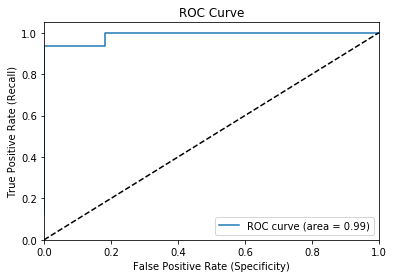

In [15]:
#2.7 ROC Curve
fpr, tpr , threshold = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Specificity: How many negatives were identified as negative.
plt.xlabel('False Positive Rate (Specificity)')
#Recall: How many positives were identified as positive.
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
#code to save your model to disk and then to s3
import pickle
local_path = "/home/ec2-user" # temp path to export your model
bucket_name = "adsbucketavc" # s3 key to save your network to

# save the model to disk
filename = '/home/ec2-user/notebook/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
#you should now see your finalized_model.sav in the file path
#the ls command prints the contents of this notebook's root folder
!ls
 
# Upload to S3
#TO GET THIS WORKING, YOU MUST ASSIGN AN ADMIN ROLE TO YOUR EC2 INSTANCE
import boto3

# Method 2: Client.put_object()
f    = open("/home/ec2-user/notebook/finalized_model.sav","rb")
text = f.read().decode(errors='replace')

client = boto3.client('s3')
client.put_object(Body=text, Bucket='adsbucketavc', Key='finalized_model.sav')



ADS_Class
Dataset_Challenge_Dataset_Agreement.pdf
finalized_model.sav
intro_to_python_data_science_on_aws.ipynb
jupyter.out
Untitled.ipynb


{'ResponseMetadata': {'RequestId': '19090AB205FC9F3F',
  'HostId': 'aNDArAg21FIALoiLeI3aCIBcEIHQp0FKtU29AmKM+kvtYClL8riWNagYO6KdIR0L/MFu+/JLLoM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'aNDArAg21FIALoiLeI3aCIBcEIHQp0FKtU29AmKM+kvtYClL8riWNagYO6KdIR0L/MFu+/JLLoM=',
   'x-amz-request-id': '19090AB205FC9F3F',
   'date': 'Tue, 11 Sep 2018 15:53:23 GMT',
   'etag': '"d26b7828d8eb15d77e3aab6343c76b09"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d26b7828d8eb15d77e3aab6343c76b09"'}

In [54]:
#2.5 Train the random forest according to the best paramater setting given above. Show model outputs.

#YOUR HOMEWORK IS TO SWITCH RANDOM FOREST CLASSIFIED WITH ANOTHER CLASSIFIER FROM THE SCIKIT LEARN API
#http://scikit-learn.org/stable/

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

clf = gnb.fit(X_train, y_train)

#importances = clf.theta_
#names = X.columns

#items=sorted(zip(map(lambda r: round(r, 3), clf.theta_), names), reverse=True)

#print ('\nfeature importance ')
#for r in items:
#    print(str(round(r[0],4))+' '+r[1])
    
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))



confusion matrix
Predicted   0   1  All
True                  
0          22   0   22
1           0  16   16
All        22  16   38

auc score 1.0
